# Анализ гипотез для увеличения выручки.

В нашем распоряжении таблица с 9-ю гипотезами по увеличению выручки и две таблицы с проевденным A/B тестом. На первом этапе необходимо приоритизировать гипотезы, использовав фреймворки ICE и RICE, написаться общие выводы. На втором этапе нужно провести анализ A/B теста.

Для выполнения первой части используем таблицу hypothesis.csv, содержащую следующие колонки: 
 * Hypothesis — краткое описание гипотезы;
 * Reach — охват пользователей по 10-балльной шкале;
 * Impact — влияние на пользователей по 10-балльной шкале;
 * Confidence — уверенность в гипотезе по 10-балльной шкале;
 * Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Для выполнения второй части будем использовать таблицу orders.csv.csv, содержащую следующие колонки: 
 * transactionId — идентификатор заказа;
 * visitorId — идентификатор пользователя, совершившего заказ;
 * date — дата, когда был совершён заказ;
 * revenue — выручка заказа;
 * group — группа A/B-теста, в которую попал заказ.  
 
и таблицу visitors.csv, содержащую следующие столбцы:
 * date — дата;
 * group — группа A/B-теста;
 * visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Последовательность действий:
* Изучить предоставленные данные.
* Провести предобработку данных:
  - проверить название колонок, тип данных в столбцах;
  - сделать проверку на наличие дубликатов;
* Приоритизировать гипотезы использовав: 
  - Использовать фреймворке ICE для приоритизации гипотез;
  - Использовать фреймворке RICE для приоритизации гипотез;
  - Сравнить результаты полученные разными методами и написать вывод.
* Проанализировать A/B тест:
   - Изучаить графики кумулятивных данных - выручки по группам, среднего чека по группам, относительного изменения среднего чека, конверсии по группам, относительного изменения конверсии по группам;
   - Анализ выбросов в данных - построить точечные график количества заказов и стоимости заказов, посчитать 95-й и 99-й перцентили количества заказов и стоимости заказов;
   - Посчитать статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным;
   - Посчитать статистическую значимость различий в конверсии и среднем чеке между группами по «очищенным» данным;
   - Сделать вывод и принять решение о дальнейшей судьбе теста.

## Изучение данных из файлов.

In [1]:
#Импортируем необходимые библиотеки для работы
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
#Загрузим данные и сохраним их в переменные
try:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
#Посмотрим информацию о таблицах
hypothesis.info()
hypothesis.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.info()
visitors.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


При рассмотрении информации о таблицах, были обнаружены следующие ошибки, которые следует исправить на этапе предобработки данных:
   1) В таблице hypothesis названия столбцов начинаются с заглавных букв - необходимо привести к единому регистру;  
   2) В таблице orders, в некоторых названиях колонок применяется "верблюжий" регистр - заменим его на "змеиный" регистр;  
   3) в таблице orders колонке date тип данных object - тип данных нужно изменить на datetime;  
   4) в таблице visitors колонке date тип данных указан как object - для дальнейшей работы изменим тип данных на datetime.

## Предобработка данных.

###  Изменение названия колонок.

In [6]:
#Приведем к единому регистру названия столбцов в таблице hypothesis
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
#Измения "верблюжий" регистр в названии столбцов таблицы orders на "змеиный"
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitors_id'})
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitors_id     1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


### Изменение типа данных в колонках.

In [8]:
#В таблицах orders и visitors изменим тип данных в колонках содержащие даты
orders['date'] = pd.to_datetime(orders['date'])

visitors['date'] = pd.to_datetime(visitors['date'])


In [9]:
#Проверим изменения
print(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitors_id     1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Проверка таблиц на наличие дубликатов и пользователей входящих в обе группы.

In [10]:
print('В таблице hypothesis явных дубликатов:', orders.duplicated().sum())
print('В таблице orders явных дубликатов:', orders.duplicated().sum())
print('В таблице visitors явных дубликатов:', orders.duplicated().sum())

В таблице hypothesis явных дубликатов: 0
В таблице orders явных дубликатов: 0
В таблице visitors явных дубликатов: 0


Проверим есть ли в таблице orders пользователи которые входят одновременно в группу A и B.

In [11]:
#Создадим переменную в которой сгруппируем данные по пользователям, 
#во втором столбце будет количество уникальных групп в которые входит пользователь
visitors_group=orders.groupby('visitors_id')['group'].nunique()
#Добавим полученную таблицу к таблице orders и посмотрим результат
df = orders.merge(visitors_group, on=["visitors_id", "visitors_id"])
print('Количество пользователей, которые одновременно учтены в двух группах',df.query('group_y>1')['visitors_id'].nunique())
df.head(5)


Количество пользователей, которые одновременно учтены в двух группах 58


,transaction_id,visitors_id,date,revenue,group_x,group_y
0,3667963787,3312258926,2019-08-15,1650,B,1
1,2804400009,3642806036,2019-08-15,730,B,1
2,2961555356,4069496402,2019-08-15,400,A,2
3,1473132782,4069496402,2019-08-12,640,B,2
4,3797467345,1196621759,2019-08-15,9759,B,1


Как видно, в таблице orders есть 58  уникальных пользователя которые находятся одновременно и в группе A и в группе B.

In [12]:
#Удалим из таблицы orders 58 пользователей, которые одновременно входят в обе группы
orders = df.query('group_y == 1').reset_index(drop=True)
#Удалим лишний столбец
orders.drop(columns = ['group_y'],axis = 1, inplace=True)
#Переименуем столбец 'group_x' в 'group', как было изначально
orders = orders.rename(columns={'group_x':'group'})
orders


,transaction_id,visitors_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1011,3592955527,608641596,2019-08-14,16490,B
1012,2662137336,3733762160,2019-08-14,6490,B
1013,2203539145,370388673,2019-08-14,3190,A
1014,1807773912,573423106,2019-08-14,10550,A


Таким образом были удалены 58 пользователей которые встречались одновременно в двух группах.

В ходе предобработки данных были устранены следующие недочеты в таблицах: 
 * все названия колонок были приведены к нижнему регистру;
 * названия слолбцов приведены к единому "змеиному" регистру;
 * в таблице orders столбце date изменен тип данных на datetime;
 * в таблице visitors столбце date изменен тип данных на datetime;
 * из таблицы orders были удалены 58 уникальных пользователей, которые одновременно встречались в группе A и B.

## Приоритизация гипотез.

### Приоритизация гипотез с помощью фреймворка  ICE.

In [13]:
#Проведем приоритизацию гипотез использовав метод ICE
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts'],3)
pd.options.display.max_colwidth = 1
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


5 самых важных гипотез, после использования метода ICE:
 1) 8  Запустить акцию, дающую скидку на товар в день рождения  
 2) 0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
 3) 7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
 4) 6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию  
 5) 2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

### Приоритизация гипотез с помощью фреймворка RICE.

In [14]:
#Проведем приоритизацию гипотез использовав метод RICE
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


5 самых важных гипотез, после использования метода RICE:
 1) 7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	   
 2) 2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    
 3) 0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
 4) 6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 
 5) 8  Запустить акцию, дающую скидку на товар в день рождения 

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2


Как можно замтетить из получившихся таблиц, топ-5 по своему наполнению идентичен, однако места приоритета разные:  
    - Так, самая важная гипотеза по методу ICE под порядковым номером 8 (Запустить акцию, дающую скидку на товар в день) оказалась только на пятом месте по методу RICE - это произошло из-за того, что показатель reach равен 1, то есть это изменения затронет небольшое количество людей.  
    - По методу RICE наиболее приоритетна, с большим отрывом, гипотеза с порядковым номером 7 (Добавить форму подписки на все основные страни...),а по методу ICE она была на 3 месте - все из-за того, что эта гипотеза имеет показатель reach максим альный равным 10, т.е. изменения затронут очень большое количество человек.
    
   Как итог, особо стоит учитывать на какое количество пользователей окажет влияние та или иная гипотеза, среди представленных наиболее приоритетны гипотезы под номерами 7, 2, 0, 6.
    

## Анализ A/B-теста

### Построение графиков кумулятивной выручки, среднего чека по группам.

Чтобы исключить проблему подсматривания, проанализируем графики метрик по группам.
Изучим графики кумулятивных данных. Для начала создадим таблицу с накопленными данными.

In [16]:
#Создадим переменную с уникальными парами дат и групп
date_groups = orders[['date','group']].drop_duplicates()
#Создадим переменную orders_aggregated и visitors_aggregated
orders_aggregated = date_groups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitors_id' : 'nunique', 'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date','group']
    )
visitors_aggregated = date_groups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}
    ), axis=1).sort_values(by=['date','group']
    )
#Объединим полученные таблицы в переменную cumulative_data
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date','group'], right_on=['date','group'])
#Переименуем названия колонок
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


In [17]:
#Объявим две переменные в разрезе групп, в которые добавим информацию о дате, выручке  и числе заказов 
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue','orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue','orders']]

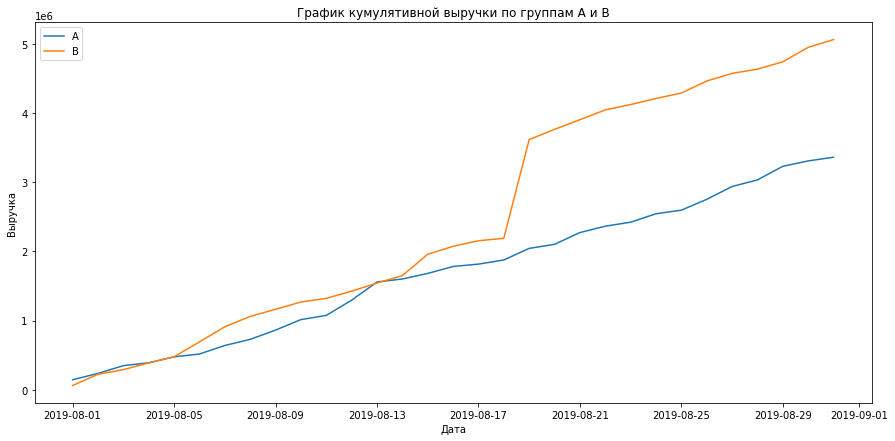

In [18]:
#Построим график кумулятивной выручки по группам
plt.figure(figsize=(15, 7))
plt.title('График кумулятивной выручки по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.plot(cumulative_revenue_a['date'],cumulative_revenue_a['revenue'],label='A')
plt.plot(cumulative_revenue_b['date'],cumulative_revenue_b['revenue'],label='B')
plt.legend()
plt.show()

До середины теста показатели у двух групп были сопоставимы, однако в середине тесте группа B резко вырвалась вперед и оставалась лучше группы A до конца теста. Возможно, резкий рост показателя выручки группы B вызван аномальными значениями в определенные дни.

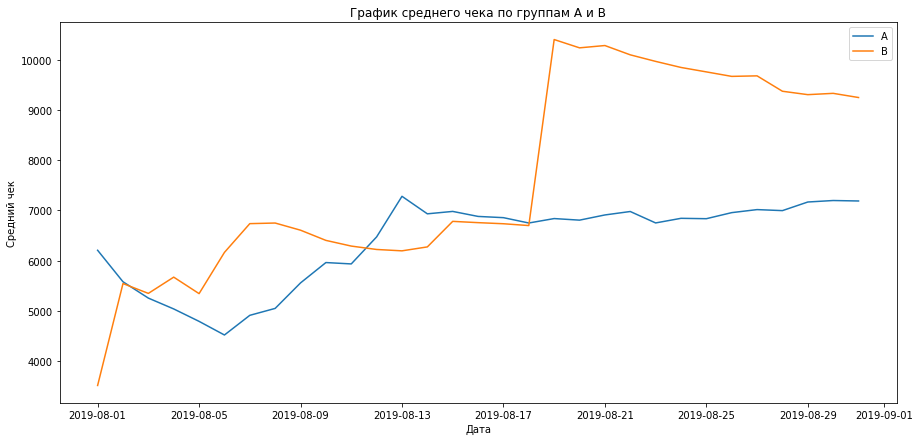

In [19]:
#Построим график кумулятивного среднего чека по группам
plt.figure(figsize=(15, 7))
plt.title('График среднего чека по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.plot(cumulative_revenue_a['date'],cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'],label='A')
plt.plot(cumulative_revenue_b['date'],cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'],label='B')
plt.legend()
plt.show()

Схожая картина с предыдущим графиком - средний чек групп колебался в пределах 5000-7000 без явного приемущества одной из групп, однако потом произошел резкий скачок у группы B и средний чек этой группы стал выше 10000. Такая картина подтверждает предположении о наличии аномальных значений выручки у пользователей группы B, в период с 2019-08-18 по 2019-08-20.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.

In [20]:
# Объединим таблицы cumulative_revenue_a и cumulative_revenue_b, 
#где общей будет дата, а выручка и количество заказов для каждой группы
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on = 'date', right_on = 'date', how = 'left', suffixes=['A', 'B'] 
)
merged_cumulative_revenue.head(5)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


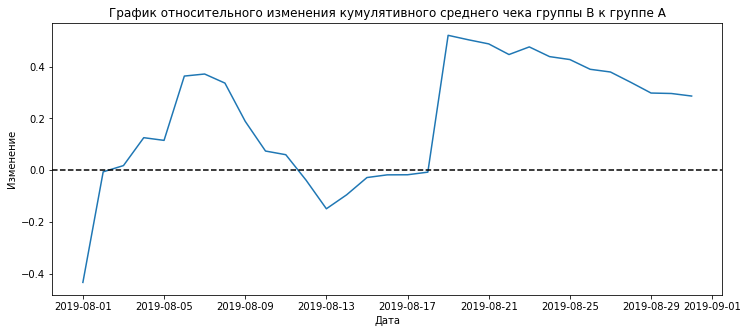

In [21]:
#Построим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(12, 5))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение')
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.show()

В самом начале средний чек был выше у группы А, затем значение колебалось и примерно выравнялось и стало около 0, однако примерно 18-19 августа 2019 резко вырос средний чек группы B вследствии чего показатель до конца теста находился существенно выше 0, т.е. уровня равенства.

### Построение графика кумулятивной конверсии по группам  и относительного изменения кумулятивной конверсии группы B к группе A.

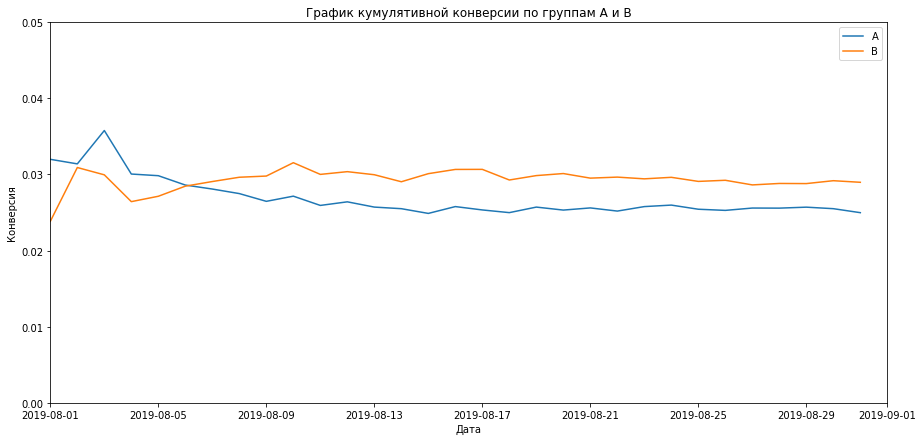

In [22]:
# К таблице cumulative_data добавим столбец с конверсией, как отношение количества заказов к количеству клиентов
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
# Создадим две переменные для двух групп которые будут содержать дату и конверсию
cumulative_conversion_a = cumulative_data[cumulative_data['group'] == 'A'][['date','conversion']]
cumulative_conversion_b = cumulative_data[cumulative_data['group'] == 'B'][['date','conversion']]
#Построим график кумулятивной конверсии по группам
plt.figure(figsize=(15, 7))
plt.title('График кумулятивной конверсии по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.plot(cumulative_conversion_a['date'], cumulative_conversion_a['conversion'],label='A')
plt.plot(cumulative_conversion_b['date'], cumulative_conversion_b['conversion'],label='B')
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.show()

В начале теста конверсия группы A была выше, однако затем конверсия группы B выросла и стала выше чем в группе A, такое распределение осталось до конца теста. Колебания конверсии наблюдалось только в начале, примерно после первой недели теста показатель конверсии устаканился и установился у своего среднего значения.

In [23]:
# Объединим таблицы cumulative_conversion_a и cumulative_conversion_b, 
#где общей будет дата и конверсия для каждой группы
merged_cumulative_conversion = cumulative_conversion_a.merge(
    cumulative_conversion_b, left_on = 'date', right_on = 'date', how = 'left', suffixes=['A', 'B'] 
)
merged_cumulative_conversion.head(5)

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


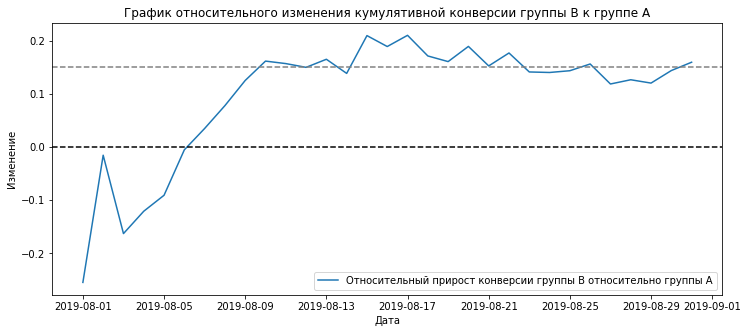

In [24]:
#Построим график относительного изменения кумулятивной конверсии группы B к группе A
plt.figure(figsize=(12, 5))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение')
plt.plot(merged_cumulative_conversion['date'],
         merged_cumulative_conversion['conversionB']/merged_cumulative_conversion['conversionA']-1,
        label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

В начале теста конверсия была лучше у группы А, однако спустя 5 дней после начала теста показатель у группы B начал стремительно расти и он стабильно зафиксировался на уровне около 15% прироста относительно группы A.

### Анализ выбросов в данных.

In [25]:
# Построим точечный график количества заказов по пользователям
# Создадим переменную которая будет содержать пользователей и количество их заказов
odrder_by_users = (orders.groupby('visitors_id', as_index=False).
agg({'transaction_id':'nunique'}))
odrder_by_users.columns=['user_id','orders']
odrder_by_users.sort_values(by='orders',ascending=False).head(5)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


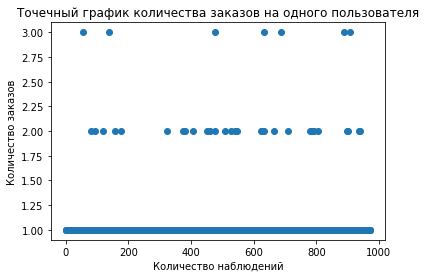

In [26]:
x_values = pd.Series(range(0, len(odrder_by_users)))
plt.scatter(x_values,odrder_by_users['orders'])
plt.title('Точечный график количества заказов на одного пользователя')
plt.xlabel('Количество наблюдений')
plt.ylabel('Количество заказов')
plt.show()

Как мы видим, самое большое значение заказов для 1 пользователя это один.

In [27]:
#Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
print(odrder_by_users.sort_values(by='orders', ascending=False).head(5))
print(np.percentile(odrder_by_users['orders'], [90, 95, 99]))

        user_id  orders
908  3967698036  3     
55   249864742   3     
478  2108163459  3     
687  2988190573  3     
890  3908431265  3     
[1. 1. 2.]


Не более 5% пользователей совершали больше одного заказа и не более 1% пользователей совершали больше двух закзов.  
За верхнюю границу можно принять пользователей с двумя заказами.


,transaction_id,visitors_id,date,revenue,group
376,590470918,1920142716,2019-08-19,1294500,B
1015,3936777065,2108080724,2019-08-15,202740,B
973,666610489,1307669133,2019-08-13,92550,A
645,3668308183,888512513,2019-08-27,86620,B
644,3603576309,4133034833,2019-08-09,67990,A
941,1348774318,1164614297,2019-08-12,66350,A
939,316924019,148427295,2019-08-12,65710,A
816,1347999392,887908475,2019-08-21,60450,A
808,2420050534,4003628586,2019-08-08,58550,B
537,4071177889,3931967268,2019-08-07,53904,B


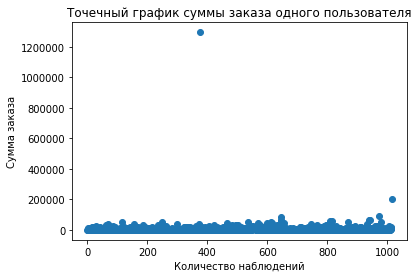

In [28]:
# Построим точечный график стоимости заказов
# Создадим переменную которая будет содержать пользователей и количество их заказов
display(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values,orders['revenue'])
plt.ticklabel_format(style='plain')
plt.title('Точечный график суммы заказа одного пользователя')
plt.xlabel('Количество наблюдений')
plt.ylabel('Сумма заказа')
plt.show()

В таблице есть очень большие значения в размере более 1.2 млн. и 200 тыс. все остальные значения до 100 тыс.

In [29]:
#Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
print(orders.sort_values(by='revenue', ascending=False).head(5))
print(np.percentile(orders['revenue'], [90, 95, 99]))

      transaction_id  visitors_id       date  revenue group
376   590470918       1920142716  2019-08-19  1294500  B   
1015  3936777065      2108080724  2019-08-15  202740   B   
973   666610489       1307669133  2019-08-13  92550    A   
645   3668308183      888512513   2019-08-27  86620    B   
644   3603576309      4133034833  2019-08-09  67990    A   
[17990. 26785. 53904.]


Не более чем у 5% заказов сумма выше 26785 и не более чем у 1% заказов сумма выше чем 53904.  
За верхнюю границу можно принять 30000.

Таким образом мы уберем из данных от 1% до 5% пользователей с большой суммой заказов и 1% пользователей с большим количеством заказов.

### Расчёт статистической значимости различий в конверсии и среднем чеке между группами по «сырым» данным.

In [30]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [31]:
# Создадим переменную для пользователей группы А, где будут столбцы с датой и количеством посетителей
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
# Переименуем названия колонок
visitors_a_daily.columns = ['date', 'visits_per_date_a']
visitors_a_daily.head(3)

,date,visits_per_date_a
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507


In [32]:
# Создадим переменную для пользователей группы А, где будет столбцы с датой и количеством посетителей
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
# Переименуем названия колонок
visitors_b_daily.columns = ['date', 'visits_per_date_b']
visitors_b_daily.head(3)

,date,visits_per_date_b
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509


In [33]:
#Из таблицы orders создадим две переменные, одна для пользователей группы A, вторая для пользователей группы B,
#переменные будут содержать информацию о клиенте и количество уникальных заказов
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitors_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
# Переименуем названия колонок
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitors_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
# Переименуем названия колонок
orders_by_users_b.columns = ['user_id', 'orders'] 

display(orders_by_users_a.head(5))
orders_by_users_b.head(5)

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [34]:
#Cоставим списки кол-ва заказов sample_a и sample_b со всеми пользователями (в том числе и не купившими) по группам 
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(visitors_a_daily['visits_per_date_a'].sum() -
                    len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(visitors_b_daily['visits_per_date_b'].sum() - 
                    len(orders_by_users_b['orders'])), name='orders')],axis=0)
sample_a

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18736, dtype: int64

Сформируем нулевую гипотезу и альтернативную, для сравнения конверсии между группами по неочищенным данным:
* Нулевая гипотеза - конверсия пользователей группы A равна конверсии пользователей группы B.
* Альтернативная гипотеза - конверсия пользователей группы A не равна конверсии пользователей группы B.  

Для проверки гипотез мы будем использовать непараметрический тест Уилкоксона-Манна-Уитни. Этот метод работает с номерами значений в упорядоченном ряду и не учитывает сами значения - это позволит нам избежать искаженных результатов из-за выбросов.   

Уровень статистической значимости примем за 0.05.

In [35]:
print('Относительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sample_b.mean()/sample_a.mean()-1))
#Рассчитаем p-value для сравнения конверсии между группами
alpha = 0.05
results = stats.mannwhitneyu(sample_a, sample_b)
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B разница статистически значима.')
else:
    print('По неочищенным данным различий в конверсии групп A и B нет.')

Относительный прирост конверсии группы B по отношению к группе A: 0.160
p-значение: 0.011018084110014696
По неочищенным данным в конверсии групп A и B разница статистически значима.


Значение P-value существенно меньше 0.05, поэтому нулевую гипотезу отвеграем. Анализ по "сырым" данным показывает, что между группами по конверсии есть статистически значимые различия. Относительный прирост конверсии группы B по отношению к группе A 16%.

Сформируем нулевую гипотезу и альтернативную, для сравнения среднего чека между группами по неочищенным данным:
* Нулевая гипотеза - средний чек пользователей группы A равен среднему чеку пользователей группы B.
* Альтернативная гипотеза - средний чек пользователей группы A не равен среднему чеку пользователей группы B.

Для проверки гипотез мы также будем использовать непараметрический тест Уилкоксона-Манна-Уитни, чтобы избежать искаженных результатов из-за выбросов.   

Уровень статистической значимости примем за 0.05.

In [36]:
#Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
print('Относительный прирост среднего чека группы B по отношению к группе A: {:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
#Рассчитаем p-value для сравнения средних чеков между группами
alpha = 0.05
results = stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('По неочищенным данным в средних чеках групп A и B разница статистически значима.')
else:
    print('По неочищенным данным различий в средних чеках групп A и B нет.')

Относительный прирост среднего чека группы B по отношению к группе A: 0.287
p-значение: 0.8294908998149533
По неочищенным данным различий в средних чеках групп A и B нет.


P-value 0.83 - статистически значимых различий в среднем чеке между группами нет, мы не можем отвергнуть нулевую гипотезу, однако относительный прирост среднего чека группы B отностиельно группы A составил 28.7%, что существенно, по всей видимости сильное влияние на показатели оказывают аномальные значения.

### Расчёт статистической значимости различий в конверсии и среднем чеке между группами по «очищенным» данным.

Сначала получим данные пользователей с аномальными значенями количества заказов и суммы одного заказа, затем уберем их из данных.

In [37]:
#Создадим переменную в которой будут пользователи, которые совершилии больше двух закзов
users_with_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id'],
     orders_by_users_b[orders_by_users_b['orders'] > 2]['user_id'],     
    ], axis=0
)
#Создадим переменную в которой будут пользователи с суммой одного заказа более 30000
users_with_expensive_orders = orders[orders['revenue']>30000]['visitors_id']
#Объединим две таблицы удалив дубликаты
ab_normal_users = pd.concat([users_with_many_orders,users_with_expensive_orders], axis=0).drop_duplicates().sort_values()
print('Количество пользователей с аномальными значениями:', len(ab_normal_users))

Количество пользователей с аномальными значениями: 49


In [38]:
#Cоставим очищенные данные о заказах по группам 
sample_a_filtered = pd.concat(
    [
    orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(ab_normal_users))]['orders'],
    pd.Series(0, index=np.arange(visitors_a_daily['visits_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')
    ],axis=0
)

sample_b_filtered = pd.concat(
    [
    orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(ab_normal_users))]['orders'],
    pd.Series(0, index=np.arange(visitors_b_daily['visits_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')
    ],axis=0
)


Сформируем нулевую гипотезу и альтернативную, для сравнения конверсии между группами по очищенным данным:
* Нулевая гипотеза - конверсия пользователей группы A равна конверсии пользователей группы B.
* Альтернативная гипотеза - конверсия пользователей группы A не равна конверсии пользователей группы B.

Для того, чтобы сопоставить результаты теста по "сырым" и "очищенным" данным, мы будем использовать тот же метод что и раньше - непараметрический тест Уилкоксона-Манна-Уитни.

Уровень статистической значимости примем за 0.05.

In [39]:
#Посчитаем статистическую значимость конверсии по группам для очищенных данных
print('Относительный прирост конверсии группы B по отношению к группе A: {:.3f}'
      .format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))
#Рассчитаем p-value для сравнения конверсии между группами
alpha = 0.05
results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B разница статистически значима.')
else:
    print('По очищенным данным РАЗЛИЧИЙ в конверсии групп A и B нет.')

Относительный прирост конверсии группы B по отношению к группе A: 0.187
p-значение: 0.009707773706615004
По очищенным данным в конверсии групп A и B разница статистически значима.


Значение P-value всё также существенно меньше 0.05, поэтому нулевую гипотезу по-прежнему не отвеграем. Анализ по "сырым" данным показывает, что между группами по конверсии есть статистически значимые различия. Относительный прирост конверсии группы B по отношению к группе A 18.7%, что еще выше чем по неочищенным данным.

Сформируем нулевую гипотезу и альтернативную, для сравнения среднего чека между группами по очищенным данным:
* Нулевая гипотеза - средний чек пользователей группы A равен среднему чеку пользователей группы B.
* Альтернативная гипотеза - средний чек пользователей группы A не равен среднему чеку пользователей группы B.

Для того, чтобы сопоставить результаты теста по "сырым" и "очищенным" данным, мы будем использовать тот же метод что и раньше - непараметрический тест Уилкоксона-Манна-Уитни.

Уровень статистической значимости примем за 0.05.

In [40]:
#Посчитаем статистическую значимость среднего чека по группам для очищенных данных
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'
      .format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitors_id'].isin(ab_normal_users)))]['revenue'].mean()/
orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitors_id'].isin(ab_normal_users)))]['revenue'].mean()-1
      )
     )
#Рассчитаем p-value для сравнения среднего чека между группами
alpha = 0.05
results = stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitors_id'].isin(ab_normal_users)))]['revenue'], 
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitors_id'].isin(ab_normal_users)))]['revenue']
)
print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print('По очищенным данным в среднем чеке групп A и B разница статистически значима.')
else:
    print('По очищенным данным различий в среднем чеке групп A и B нет.')


Относительный прирост конверсии группы B по отношению к группе A: -0.027
p-значение: 0.7408811467812091
По очищенным данным различий в среднем чеке групп A и B нет.


По очищенным данным P-value 0.74 - статистически значимых различий в среднем чеке между группами нет, мы не можем отвергнуть нулевую гипотезу, также и относительного прироста среднего чека группы B отностиельно группы A нет, показатель около 2%.

### Выводы и решение по результатам теста.

**Выводы по результатам теста:**
 * Между группами есть статистически значимое различие в показатели конверсии, как по "сырым" данным так и по "очищенным".
 * По "сырым" и "очищенным" данным нет статистически значимого различия по показателю среднего чека между группами A и B.
 * По кумулятивным метрикам выручки, среднего чека и конверсии, практически всегда лидировала группа B.
 * Относительный прирост конверсии группы B по отношению к группе A после очищения данных от аномалий  возрос с 16% до 18.7%.
 * По графику конверсии видно, что конверсия пользователей группы B стабильно выше чем у пользователей группы A и значение зафиксировалось на отметке около 15%.

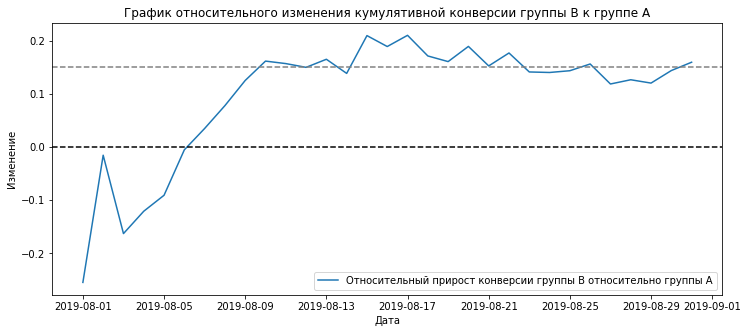

In [41]:
plt.figure(figsize=(12, 5))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение')
plt.plot(merged_cumulative_conversion['date'],
         merged_cumulative_conversion['conversionB']/merged_cumulative_conversion['conversionA']-1,
        label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()


**Учитывая убедительное приемущество группы B в показатели конверсии, при сравнимом значении среднего чека с группой А, можно сделать вывод о победе группы B и завершить тест.**

**Общие выводы:**
* В предоставленных таблицах была проведена предобработка данных, включающая:
  * Изменение названия колонок - приведение всех символов к нижнему регистру и использование "змеиного" регистра;
  * Изменение типа данных в столбцах, где это было необходимо;
  * Проверка данных на дубликаты;
  * Удаление пользователей находившихся одновременно в группе A и B.
  
  

* Следующим этапом была произведена приоритизация девяти гипотез с помощью фреймворков ICE и RICE:
  * Топ-5 самых важных гипотез совпал, по результатам исследования обоими методами, однако распределение по местам было разное. Особое значение стоит обращать на какое количество пользователей окажет влияние та или иная гипотеза. 
  * Среди представленных гипотез наиболее приоритетны оказались гипотезы под номерами 7, 2, 0, 6.
  

* Следующим этапом был произведен анализ A/B теста:
  * Построены и проанализированы графики кумулятивной выручки, среднего чека, конверсии и относительного изменения кумулятивного среднего чека и конверсии группы B к группе A;
  * По кумулятивным метрикам практически всегда лидировала группа B;
  * Используя 95-й и 99-й перцентили были опрелены границы по количеству заказов и сумме заказов для аномальных пользователей и аномальных заказов;
  * Была изучена статистическая значимость различий в конверсии и серднем чеке между группами A и B по "сырым" и "очищенным"  данным. В ходе анализа этих данных была выявлена разница в показатели конверсии и зафиксирована победа пользователей группы  B.
